## Applied Deep Learning in Intracranial Neurophysiology Workshop
### Adversarial Domain Adaptation for Stable Brain-Machine Interfaces https://arxiv.org/pdf/1810.00045.pdf

This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL), prepared generously by [Dr. Ali Farshchian](https://www.researchgate.net/profile/Ali_Farshchian). The original version can be found on his [GitHub page](https://github.com/farshchian/ADAN).

<table><td><a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/08_01_ADAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td></table>

### Dependencies

In [1]:
# Normalize local and google colab environments.
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    os.chdir('..')
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    # !pip install tensorflow==1.10.0
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)

Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1184 (delta 28), reused 19 (delta 8), pack-reused 1127
Receiving objects: 100% (1184/1184), 311.81 MiB | 45.88 MiB/s, done.
Resolving deltas: 100% (705/705), done.
Checking out files: 100% (93/93), done.


In [0]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
from indl.adan import utils
from tqdm import tqdm_notebook

plt.rcParams.update({'font.size': 22})

### Loading Data

In [0]:
datadir = Path.cwd() / 'data' / 'ADAN'
data_files = [f for f in os.listdir(path=str(datadir)) if f.endswith('.mat')]
data={}
for i,f in enumerate(data_files):
    raw_data = sio.loadmat(datadir/f, squeeze_me=True)
    data['rate'+str(i)],data['EMG'+str(i)]=utils.load_data(raw_data)

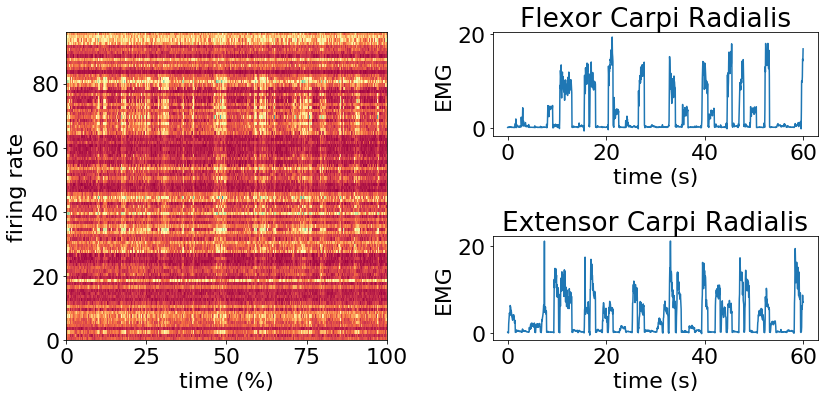

In [7]:
plt.figure(figsize=(12,6), facecolor='white')

plt.subplot(2, 2, (1,3))
plt.imshow(np.transpose(data['rate0']),cmap='Spectral',extent=[0,100,0,96])
plt.xlabel('time (%)')
plt.ylabel('firing rate')

plt.subplot(2, 2, 2)
t = np.linspace(0., 60., 1200, endpoint=True)
plt.plot(t,data['EMG0'][:1200,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2, 2, 4)
plt.plot(t,data['EMG0'][:1200,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')

plt.tight_layout()
plt.show()

## Day-0 Decoder
![ADAN](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/ADAN.png?raw=1)

### Decoder Hyperparameters

In [0]:
spike_dim = 96
emg_dim = 14
latent_dim = 10
batch_size = 64
n_steps = 4
n_layers = 1
n_epochs = 400
lr = 0.001

### Decoder Graph

In [9]:
tf.reset_default_graph()
tf.set_random_seed(seed=42)

spike = tf.placeholder(tf.float32, (None,spike_dim), name='spike')
emg = tf.placeholder(tf.float32, (None,emg_dim), name='emg')
gamma = tf.placeholder(tf.float32)

def autoencoder(input_, n_units=[64,32,latent_dim], reuse=False):
    with tf.variable_scope('autoencoder', reuse=reuse):
        h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
        h2 = tf.layers.dense(h1, units=n_units[1], activation=tf.nn.elu)
        latent = tf.layers.dense(h2, units=n_units[2], activation=None)
        h3 = tf.layers.dense(latent, units=n_units[1], activation=tf.nn.elu)
        h4 = tf.layers.dense(h3, units=n_units[0], activation=tf.nn.elu)
        logits = tf.layers.dense(h4, units=spike_dim, activation=None)
        return latent, logits

latent,logits = autoencoder(spike)

def emg_decoder(latent, reuse=False):
    with tf.variable_scope('emg_decoder', reuse=reuse):
        latent = tf.reshape(latent,[-1,n_steps,latent_dim])
        layers = [tf.nn.rnn_cell.LSTMCell(num_units=emg_dim,activation=tf.nn.elu) for layer in range(n_layers)]
        multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
        outputs, states = tf.nn.dynamic_rnn(multi_layer_cell,latent, dtype=tf.float32)
        emg_hat = tf.layers.dense(outputs, units=emg_dim, activation=None)
        emg_hat = tf.reshape(emg_hat,[-1,emg_dim])
        return emg_hat

emg_hat = emg_decoder(latent)
emg_hat = tf.identity(emg_hat, name='emg_hat')

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Decoder Losses and Optimizers

In [0]:
ae_loss = tf.reduce_mean(tf.square(logits - spike))
emg_loss = tf.reduce_mean(tf.square(emg_hat - emg))
total_loss = gamma*ae_loss+emg_loss
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(total_loss)

### Training and Test Set

In [0]:
spike_day0 = data['rate0']
emg_day0 = data['EMG0']
idx = int((len(spike_day0)//n_steps)*n_steps*0.82)
r = len(spike_day0)%n_steps

spike_tr = spike_day0[:idx]
emg_tr = emg_day0[:idx]
spike_te = spike_day0[idx:-r]
emg_te = emg_day0[idx:-r]

### Decoder Training

In [12]:
n_batches = idx//batch_size
gamma_ = np.float32(1.)
saver = tf.train.Saver(max_to_keep=1)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    for epoch in tqdm_notebook(range(n_epochs)):
        spike_gen_obj = utils.get_batches(spike_tr,batch_size)
        emg_gen_obj = utils.get_batches(emg_tr,batch_size)
        for ii in range(n_batches):
            spike_batch = next(spike_gen_obj)
            emg_batch = next(emg_gen_obj)
            sys.stdout.flush()
            sess.run(optimizer,feed_dict={spike:spike_batch,emg:emg_batch,gamma:gamma_})
        ae_loss_ = ae_loss.eval(feed_dict={spike:spike_tr,emg:emg_tr,gamma:gamma_})
        emg_loss_ = emg_loss.eval(feed_dict={spike:spike_tr,emg:emg_tr,gamma:gamma_})
        gamma_ = emg_loss_/ae_loss_
        if (epoch % 50 == 0) or (epoch == n_epochs-1): 
            spike_hat_tr,spike_hat_te = [logits.eval(feed_dict={spike:spike_tr}),logits.eval(feed_dict={spike:spike_te})]
            emg_hat_tr,emg_hat_te = [emg_hat.eval(feed_dict={spike:spike_tr,emg:emg_tr}),
                                     emg_hat.eval(feed_dict={spike:spike_te,emg:emg_te})]
            print("Epoch:", epoch, "\tAE_loss:",ae_loss_, "\tEMG_loss:",emg_loss_)
            print("AE Train %VAF:", utils.vaf(spike_tr,spike_hat_tr),"\AE Test %VAF:", utils.vaf(spike_te,spike_hat_te))
            print("EMG Train %VAF:", utils.vaf(emg_tr,emg_hat_tr),"\EMG Test %VAF:", utils.vaf(emg_te,emg_hat_te))
    saver.save(sess, "./Models/decoder")

Epoch: 0 	AE_loss: 0.7233407 	EMG_loss: 12.298606
AE Train %VAF: 41.39422736322217 \AE Test %VAF: 40.74873427821646
EMG Train %VAF: 23.116666421759035 \EMG Test %VAF: 23.843411836415772
Epoch: 50 	AE_loss: 0.23736988 	EMG_loss: 1.4445971
AE Train %VAF: 81.44729384274825 \AE Test %VAF: 81.64812727633922
EMG Train %VAF: 89.98143833400948 \EMG Test %VAF: 83.71880824833899
Epoch: 100 	AE_loss: 0.22136791 	EMG_loss: 1.2828474
AE Train %VAF: 82.51214162627495 \AE Test %VAF: 82.18251758838974
EMG Train %VAF: 91.13585926645122 \EMG Test %VAF: 84.92116384003351
Epoch: 150 	AE_loss: 0.21848807 	EMG_loss: 1.3099432
AE Train %VAF: 82.88044604771184 \AE Test %VAF: 81.98286024815685
EMG Train %VAF: 91.02678099430523 \EMG Test %VAF: 85.22746168573299
Epoch: 200 	AE_loss: 0.20904464 	EMG_loss: 1.0065576
AE Train %VAF: 83.3832064669731 \AE Test %VAF: 81.97542076126517
EMG Train %VAF: 93.04650107478074 \EMG Test %VAF: 82.9399477574772
Epoch: 250 	AE_loss: 0.20954631 	EMG_loss: 1.0991617
AE Train %VAF: 8

### EMG Predictions (Day-0)

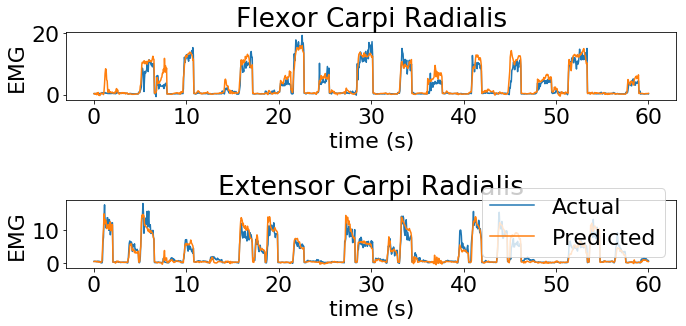

In [13]:
t = np.linspace(0., 60., 1056, endpoint=True)
plt.figure(figsize=(10,5), facecolor='white')

plt.subplot(2,1,1)
plt.plot(t,emg_te[:1056,0],t,emg_hat_te[:1056,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2,1,2)
plt.plot(t,emg_te[:1056,11],t,emg_hat_te[:1056,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')
plt.legend(('Actual','Predicted'))

plt.tight_layout()
plt.show()

## Domain Adaptation
![ADAN2](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/ADAN2.png?raw=1)

### ADAN Hyperparameters

In [0]:
n_epochs = 50
batch_size = 16
d_lr = 0.00001
g_lr = 0.0001

### ADAN Graph

In [0]:
tf.reset_default_graph()
tf.set_random_seed(seed=42)

g = tf.train.import_meta_graph('./Models/decoder.meta')
graph = tf.get_default_graph()
spike = graph.get_tensor_by_name("spike:0")
emg_hat =  graph.get_tensor_by_name(name="emg_hat:0")

input_day0 = tf.placeholder(tf.float32, (None, spike_dim), name='input_day0')
input_dayk = tf.placeholder(tf.float32, (None, spike_dim), name='input_dayk')

def generator(input_, reuse=False):
    with tf.variable_scope('generator',initializer=tf.initializers.identity(),reuse=reuse):
        h1 = tf.layers.dense(input_,spike_dim,activation=None)
        output  = tf.layers.dense(h1,spike_dim,activation=None)
    return output

def discriminator(input_, n_units=[64,32,latent_dim], reuse=False):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        noise = tf.random_normal(tf.shape(input_), dtype=tf.float32)
        input_ = input_+noise
        h1 = tf.layers.dense(input_, units=n_units[0], activation=tf.nn.elu)
        h2 = tf.layers.dense(h1, units=n_units[1], activation=tf.nn.elu)
        latent = tf.layers.dense(h2, units=n_units[2], activation=None)
        h3 = tf.layers.dense(latent, units=n_units[1], activation=tf.nn.elu)
        h4 = tf.layers.dense(h3, units=n_units[0], activation=tf.nn.elu)
        logits = tf.layers.dense(h4, units=spike_dim, activation=None)
        return latent, logits

input_dayk_aligned = generator(input_dayk)
latent_day0,logits_day0 = discriminator(input_day0)
latent_dayk,logits_dayk = discriminator(input_dayk_aligned)

### ADAN Losses and Optimizers

In [0]:
d_loss_0 = tf.reduce_mean(tf.abs(logits_day0-input_day0)) 
d_loss_k = tf.reduce_mean(tf.abs(logits_dayk-input_dayk_aligned))
d_loss = d_loss_0 - d_loss_k
g_loss = d_loss_k

t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_opt = tf.train.AdamOptimizer(learning_rate=d_lr).minimize(d_loss, var_list=d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=g_lr).minimize(g_loss, var_list=g_vars)

### ADAN Training

In [17]:
r = len(data['rate1'])%n_steps
spike_dayk = data['rate1'][:-r]
emg_dayk = data['EMG1'][:-r] 
n_batches = min(len(spike_day0),len(spike_dayk))//(batch_size)

a_vars = [var.name for var in t_vars if var.name.startswith('autoencoder')]
for i,name in enumerate(a_vars):
    tf.train.init_from_checkpoint('./Models/', {name[:-2]:d_vars[i]})

init = tf.global_variables_initializer()
with tf.Session() as sess: 
        init.run()
        g.restore(sess, tf.train.latest_checkpoint('./Models/'))
        for epoch in tqdm_notebook(range(n_epochs)):
            spike_0_gen_obj = utils.get_batches(spike_day0,batch_size)
            spike_k_gen_obj = utils.get_batches(spike_dayk,batch_size)
            for ii in range(n_batches):
                spike_0_batch = next(spike_0_gen_obj)
                spike_k_batch = next(spike_k_gen_obj)
                sys.stdout.flush()
                _,g_loss_ = sess.run([g_opt,g_loss],feed_dict={input_day0:spike_0_batch,input_dayk:spike_k_batch})
                _,d_loss_0_,d_loss_k_ = sess.run([d_opt,d_loss_0,d_loss_k],feed_dict={input_day0:spike_0_batch,input_dayk:spike_k_batch})
            if (epoch % 10 == 0) or (epoch == n_epochs-1):
                print("\r{}".format(epoch), "Discriminator loss_day_0:",d_loss_0_,"\Discriminator loss_day_k:",d_loss_k_)
                input_dayk_aligned_ = input_dayk_aligned.eval(feed_dict={input_dayk:spike_dayk})
                emg_dayk_aligned = emg_hat.eval(feed_dict={spike:input_dayk_aligned_})
                emg_k_ = emg_hat.eval(feed_dict={spike:spike_dayk})
                print("EMG non-aligned VAF:", utils.vaf(emg_dayk,emg_k_),"\tEMG aligned VAF:", utils.vaf(emg_dayk,emg_dayk_aligned))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./Models/decoder


0 Discriminator loss_day_0: 0.39919186 \Discriminator loss_day_k: 0.5091668
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 67.92935676997882
10 Discriminator loss_day_0: 0.45040908 \Discriminator loss_day_k: 0.47185764
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 66.03604107466714
20 Discriminator loss_day_0: 0.48771492 \Discriminator loss_day_k: 0.40568945
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 69.22303405023878
30 Discriminator loss_day_0: 0.45819297 \Discriminator loss_day_k: 0.42367947
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 68.97488231716706
40 Discriminator loss_day_0: 0.5246157 \Discriminator loss_day_k: 0.46536565
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 69.13360557125799
49 Discriminator loss_day_0: 0.51058304 \Discriminator loss_day_k: 0.47550225
EMG non-aligned VAF: 44.26440999302403 	EMG aligned VAF: 70.24023709432397



### EMG Predictions (Day-16) Before & After Alignment

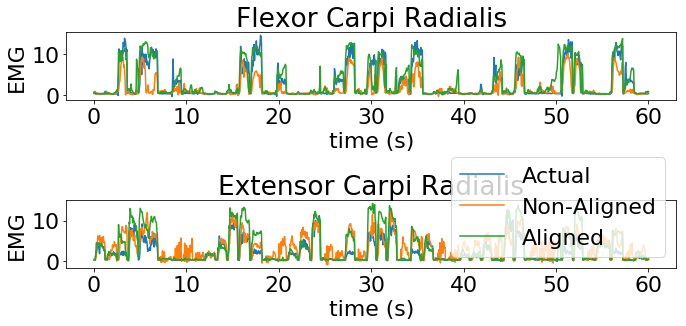

In [18]:
t = np.linspace(0., 60., 1200, endpoint=True)

plt.figure(figsize=(10,5), facecolor='white')

plt.subplot(2,1,1)
plt.plot(t,emg_dayk[:1200,0],t,emg_k_[:1200,0],t,emg_dayk_aligned[:1200,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2,1,2)
plt.plot(t,emg_dayk[:1200,11],t,emg_k_[:1200,11],t,emg_dayk_aligned[:1200,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')
plt.legend(('Actual','Non-Aligned','Aligned'))

plt.tight_layout()
plt.show()